## Transfer Learning with TensorFlow, scaling up (🍔👀Food Vision mini)

We've seen the power of transfer learning feature extraction and fine_tuning, now it's time to scale up to all of the classes in food101 (101 totl classes of food).

Our goual is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper [here](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf).

Our baseline to beat is 50.76% accuracy across 101 classes

In [1]:
# Check connection
!nvidia-smi

Fri Jan 26 20:41:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

Download the helper functions

In [51]:
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py

--2024-01-26 21:10:26--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13380 (13K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  13.07K  --.-KB/s    in 0.002s  

2024-01-26 21:10:26 (5.27 MB/s) - ‘helper.py’ saved [13380/13380]



In [55]:
# Import series of helper functions for our notebook
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 FoodClasses: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the [image_data_modification](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) notebook.

In [4]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-01-26 20:41:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.207, 173.194.174.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  21.5MB/s    in 74s     

2024-01-26 20:42:29 (20.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 dire

In [6]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we´re going to take:
* Create a `ModelCheckpoint` callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # To save time, if False it'll take alot of time to sve the whole model
                                                         monitor="val_accuracy",
                                                         save_best_only=True) # Saves the best weights for val_accuracy

In [8]:
# Create data augmentation layer (If we put it into the model the augmentation will happen o the GPU wich is faster)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) # Can be skipped when using EfficieNet models (built in)
], name="data_augmentation")

In [9]:
# Setup the base model and freeze it layers (this will extrac features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False;

# Setup model arcitecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the bas model in inference mode so weights wich needs to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="blobal_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # Output neurons = 101(classes)
# Create the model
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


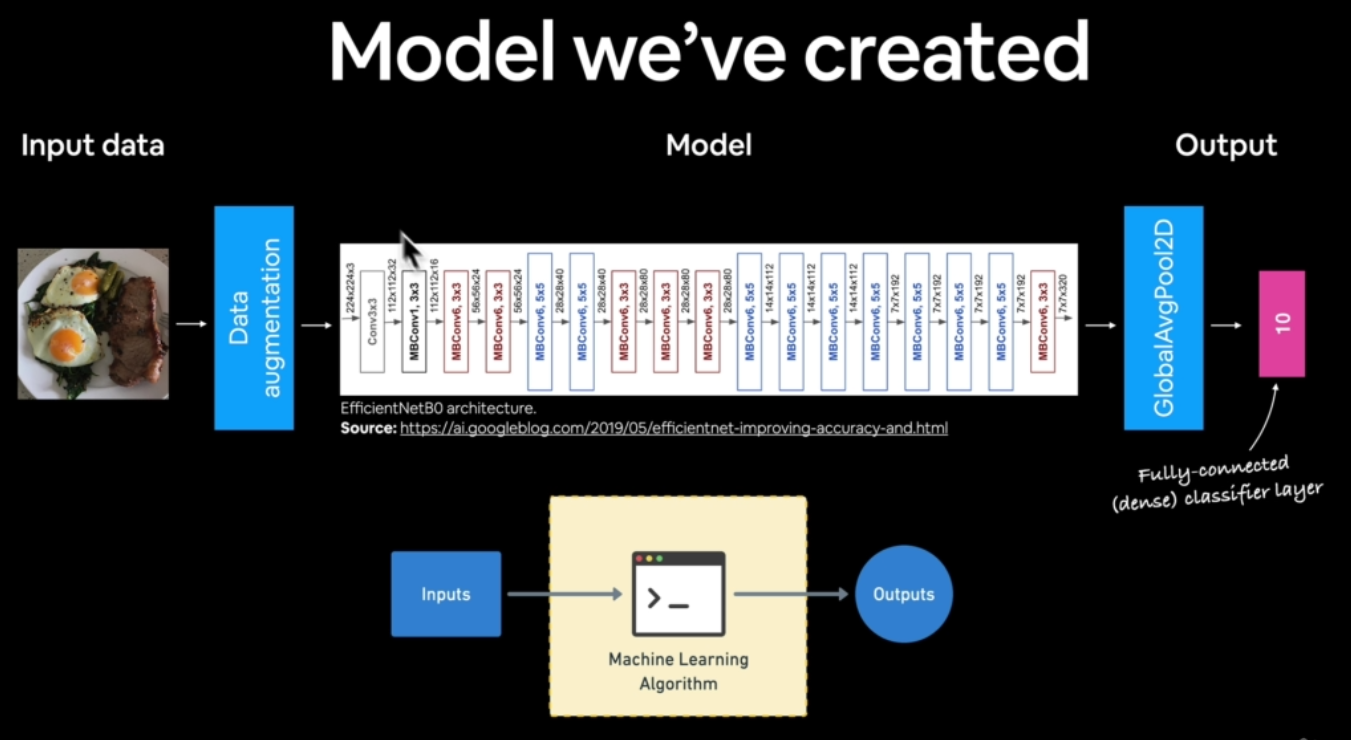

In [10]:
# Get a summmary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 blobal_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs for quick exp
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 144s 571ms/step - loss: 3.3644 - accuracy: 0.2764 - val_loss: 2.5676 - val_accuracy: 0.4306
Epoch 2/5
237/237 [==============================] - 94s 397ms/step - loss: 2.2003 - accuracy: 0.4929 - val_loss: 2.0816 - val_accuracy: 0.5034
Epoch 3/5
237/237 [==============================] - 78s 329ms/step - loss: 1.8277 - accuracy: 0.5659 - val_loss: 1.9084 - val_accuracy: 0.5175
Epoch 4/5
237/237 [==============================] - 74s 310ms/step - loss: 1.6164 - accuracy: 0.6075 - val_loss: 1.8217 - val_accuracy: 0.5352
Epoch 5/5
237/237 [==============================] - 67s 284ms/step - loss: 1.4576 - accuracy: 0.6449 - val_loss: 1.7870 - val_accuracy: 0.5294


In [12]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 47s 60ms/step - loss: 1.5908 - accuracy: 0.5808


[1.5907926559448242, 0.5807920694351196]

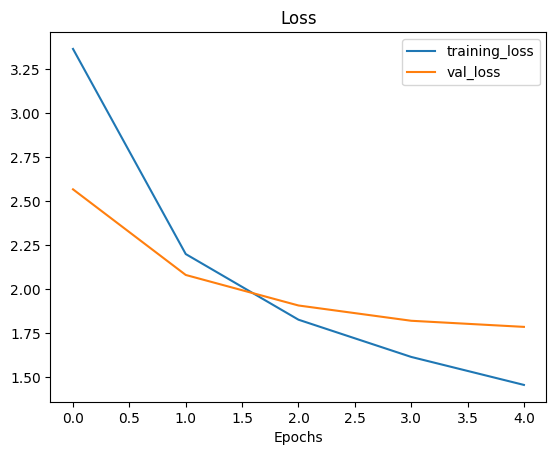

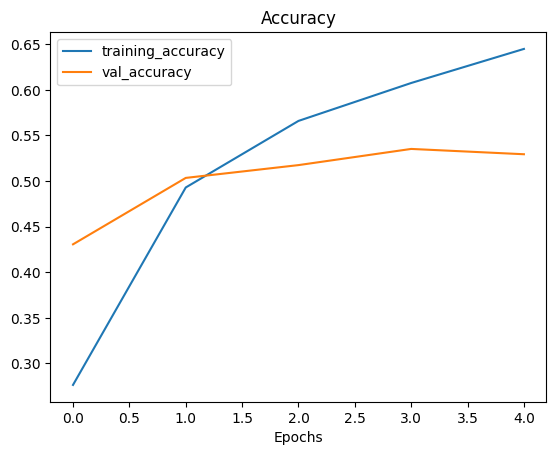

In [13]:
# Plot loss curves, overfitting :P
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [15]:
# Recompile model with lower learning rate (best practice to lower lr when unfreeze layers)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
blobal_avg_pool_layer True
output_layer True


In [17]:
# Check wich layres are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [18]:
# Fine tune for 5 more epochs were we left off last traning
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_tune_all_classes_ten_percent = model.fit(train_data_all_10_percent,
                                                           epochs=fine_tune_epochs,
                                                           validation_data=test_data,
                                                           validation_steps=int(0.15 * len(test_data)),
                                                           initial_epoch=history_all_classes_10_percent.epoch[-1],
                                                           callbacks=[create_tensorboard_callback(dir_name="transfer_lerning", # Not necessary
                                                                                                  experiment_name="10_percent_all_classes_last_five_layers_fine_tuned")])

Saving TensorBoard log files to: transfer_lerning/10_percent_all_classes_last_five_layers_fine_tuned/20240126-205115
Epoch 5/10
237/237 [==============================] - 71s 270ms/step - loss: 1.5029 - accuracy: 0.5946 - val_loss: 1.7419 - val_accuracy: 0.5416
Epoch 6/10
237/237 [==============================] - 58s 247ms/step - loss: 1.0790 - accuracy: 0.7044 - val_loss: 1.9778 - val_accuracy: 0.4997
Epoch 7/10
237/237 [==============================] - 53s 223ms/step - loss: 0.8353 - accuracy: 0.7632 - val_loss: 1.9386 - val_accuracy: 0.5270
Epoch 8/10
237/237 [==============================] - 51s 216ms/step - loss: 0.6454 - accuracy: 0.8143 - val_loss: 2.1013 - val_accuracy: 0.5058
Epoch 9/10
237/237 [==============================] - 50s 211ms/step - loss: 0.5261 - accuracy: 0.8462 - val_loss: 2.3583 - val_accuracy: 0.4838
Epoch 10/10
237/237 [==============================] - 45s 189ms/step - loss: 0.4397 - accuracy: 0.8673 - val_loss: 2.5816 - val_accuracy: 0.4489


In [19]:
# Evaluate the fine tuned model
results_fine_tune_10_percent_all_classes = model.evaluate(test_data)
results_fine_tune_10_percent_all_classes

790/790 [==============================] - 48s 60ms/step - loss: 1.9867 - accuracy: 0.5528


[1.9866929054260254, 0.5527524948120117]

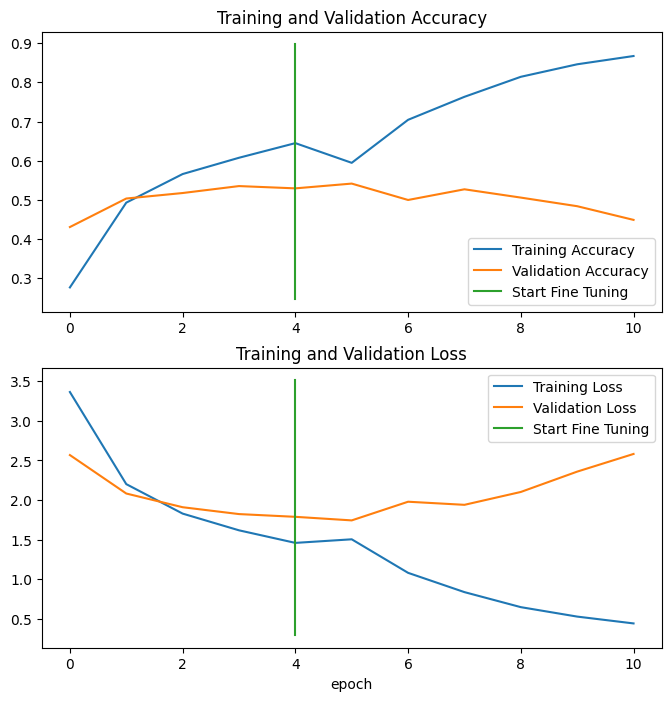

In [20]:
# Check the loss curves, model is overfittning on the training data
compare_historys(history_all_classes_10_percent,
                 history_fine_tune_all_classes_ten_percent,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [21]:
# save our fine-tuning model (to google drive)
model.save("drive/MyDrive/TensorFlow/101_foof_classes_10_percent_saved_model")

In [22]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/TensorFlow/101_foof_classes_10_percent_saved_model")

In [23]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 49s 60ms/step - loss: 1.9867 - accuracy: 0.5528


[1.9866929054260254, 0.5527524948120117]

In [24]:
# The results from our loaded model (above) should be very similar to the results below
results_fine_tune_10_percent_all_classes

[1.9866929054260254, 0.5527524948120117]

## Evaluating the performance of the model across different classes

Let's make predictions, visualize them and later find out wich predictions were the "most" wrong.

In [25]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbose to see how long is left

790/790 [==============================] - 46s 57ms/step


In [26]:
len(test_data)

790

In [27]:
# How many predictions are there?
len(preds_probs)

25250

In [28]:
# Whats the shape of our predictions?
preds_probs.shape

(25250, 101)

In [29]:
# Let's see what the 10 first predictions look like
preds_probs[:10]

array([[2.42806561e-02, 1.07379667e-04, 2.66335974e-03, ...,
        3.46847543e-07, 4.07702988e-03, 3.41488095e-03],
       [9.54700887e-01, 1.26353115e-08, 8.64942922e-06, ...,
        3.57419685e-06, 5.35409086e-08, 1.21238264e-08],
       [8.16835016e-02, 1.01005603e-02, 3.74430849e-04, ...,
        1.01788275e-04, 7.30586005e-04, 1.79699378e-03],
       ...,
       [2.03359150e-03, 5.41956202e-10, 1.41668124e-07, ...,
        3.37712154e-05, 4.79613982e-06, 7.84584770e-08],
       [3.09403121e-01, 1.70830990e-05, 1.63570210e-01, ...,
        2.57732900e-04, 3.96279793e-05, 4.83768381e-05],
       [5.57050228e-01, 1.86619559e-07, 1.09420753e-05, ...,
        2.44549417e-04, 1.47190448e-07, 1.36747640e-05]], dtype=float32)

In [30]:
# What does the first prediction probability array looks like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([2.42806561e-02, 1.07379667e-04, 2.66335974e-03, 1.28617519e-10,
        2.25315464e-08, 2.70906160e-08, 2.34819083e-07, 1.49152726e-08,
        6.55306067e-05, 2.03388140e-06, 1.20445577e-06, 1.92033092e-08,
        9.24129608e-07, 1.29372513e-08, 2.65995295e-05, 4.05994979e-05,
        1.03775237e-08, 1.36038498e-05, 3.10820527e-03, 8.23149549e-06,
        1.67644641e-04, 1.13920301e-07, 2.10176149e-05, 2.56678468e-04,
        1.06455818e-05, 1.63589910e-04, 7.79157272e-04, 1.10557075e-05,
        1.10344458e-02, 8.11488644e-05, 4.96341727e-07, 1.58765441e-04,
        5.01484137e-05, 7.73465842e-07, 2.18913448e-03, 1.55494234e-07,
        1.00848524e-07, 6.76585041e-05, 9.25505185e-04, 1.07485357e-05,
        7.72208441e-05, 1.78984564e-03, 2.96267990e-06, 2.69773068e-06,
        1.01180740e-04, 4.77942331e-06, 6.21933650e-05, 6.49149399e-07,
        6.97226099e-08, 2.84827268e-03, 5.22284427e-06, 1.05569916e-06,
        7.95011103e-01, 5.28117344e-02, 1.31565707e-06, 1.382049

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [31]:
# We get one pred probability per class( in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [2.42806561e-02 1.07379667e-04 2.66335974e-03 1.28617519e-10
 2.25315464e-08 2.70906160e-08 2.34819083e-07 1.49152726e-08
 6.55306067e-05 2.03388140e-06 1.20445577e-06 1.92033092e-08
 9.24129608e-07 1.29372513e-08 2.65995295e-05 4.05994979e-05
 1.03775237e-08 1.36038498e-05 3.10820527e-03 8.23149549e-06
 1.67644641e-04 1.13920301e-07 2.10176149e-05 2.56678468e-04
 1.06455818e-05 1.63589910e-04 7.79157272e-04 1.10557075e-05
 1.10344458e-02 8.11488644e-05 4.96341727e-07 1.58765441e-04
 5.01484137e-05 7.73465842e-07 2.18913448e-03 1.55494234e-07
 1.00848524e-07 6.76585041e-05 9.25505185e-04 1.07485357e-05
 7.72208441e-05 1.78984564e-03 2.96267990e-06 2.69773068e-06
 1.01180740e-04 4.77942331e-06 6.21933650e-05 6.49149399e-07
 6.97226099e-08 2.84827268e-03 5.22284427e-06 1.05569916e-06
 7.95011103e-01 5.28117344e-02 1.31565707e-06 1.38204914e-05
 5.67638526e-05 3.55609955e-05 9.02417931e-

In [32]:
test_data.class_names[0]

'apple_pie'

In [33]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  8,  8,  8, 78, 29, 62,  0,  0])

In [34]:
# How many pred clases do we have?
len(pred_classes)

25250

Now we'vegot a predictions array of all of our models predictions, to evaluate them, we need to compare them to original test dataset


In [35]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently test labels look llike-. [0, 0, 0, 1, ..... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # Look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [36]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same orde as our test labels array is to find the accuracy score

In [37]:
results_fine_tune_10_percent_all_classes

[1.9866929054260254, 0.5527524948120117]

In [38]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

sklearn_accuracy

0.5527524752475248

In [39]:
# Does this metric come close to our model's evaluate results?
import numpy as np
np.isclose(results_fine_tune_10_percent_all_classes[1], sklearn_accuracy)

True

## Let's get visual: making a configuration matrix


## Let's get visual: making a confusion matrix

In [40]:
# Import helper function
from helper import make_confusion_matrix

In [41]:
# Get  list of class names
class_names= test_data.class_names
# Print out 10
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [54]:
from helper import make_confusion_matrix_with_x_axis_labels_rotated

In [43]:
make_confusion_matrix_with_x_axis_labels_rotated(y_true=y_labels,
                                                y_pred=pred_classes,
                                                classes=class_names,
                                                figsize=(100, 100),
                                                text_size=20,
                                                savefig=True)

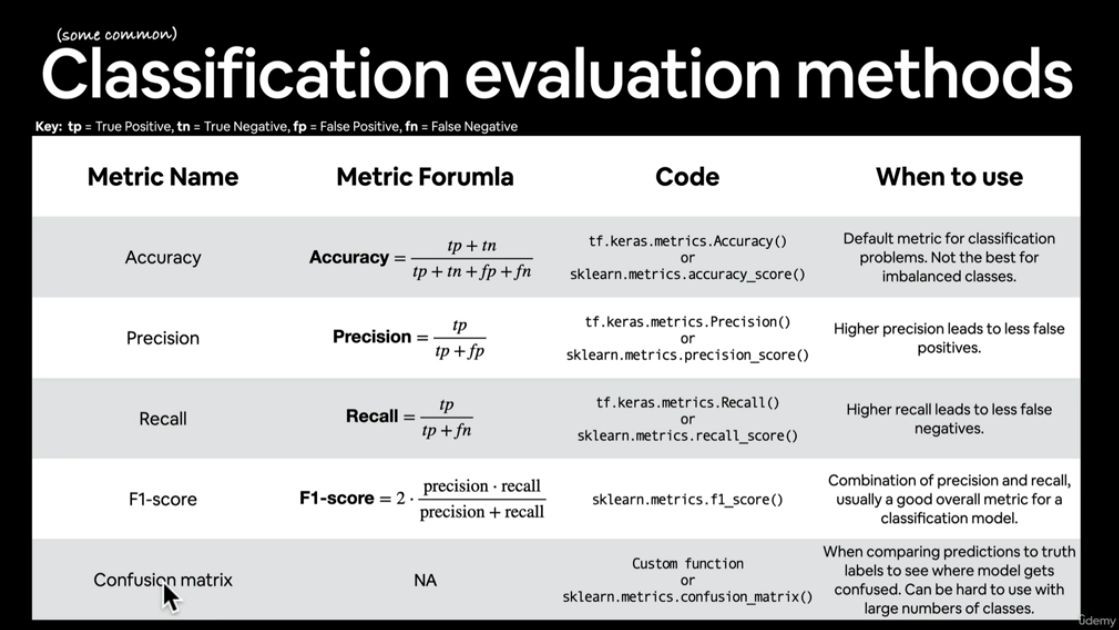

## Let's keep the evaluation going, time for classification report

Scikit-learn has a helpfuk function for acquiring many different classification metrics per class (e.g precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) , lets try that out.


In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.28      0.22      0.24       250
           1       0.45      0.71      0.55       250
           2       0.80      0.48      0.60       250
           3       0.75      0.48      0.59       250
           4       0.45      0.42      0.44       250
           5       0.58      0.35      0.43       250
           6       0.78      0.76      0.77       250
           7       0.93      0.45      0.60       250
           8       0.21      0.60      0.31       250
           9       0.59      0.45      0.51       250
          10       0.64      0.32      0.43       250
          11       0.85      0.40      0.54       250
          12       0.84      0.42      0.56       250
          13       0.65      0.55      0.60       250
          14       0.91      0.16      0.27       250
          15       0.63      0.12      0.20       250
          16       0.91      0.19      0.32       250
          17       0.31    

The nubers above give a great class-by-class evaluation of our model's predictions but with so many classses, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [57]:
# Get a dictonary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.2755102040816326,
  'recall': 0.216,
  'f1-score': 0.242152466367713,
  'support': 250},
 '1': {'precision': 0.4481012658227848,
  'recall': 0.708,
  'f1-score': 0.5488372093023256,
  'support': 250},
 '2': {'precision': 0.7986577181208053,
  'recall': 0.476,
  'f1-score': 0.5964912280701753,
  'support': 250},
 '3': {'precision': 0.75,
  'recall': 0.48,
  'f1-score': 0.5853658536585366,
  'support': 250},
 '4': {'precision': 0.4491525423728814,
  'recall': 0.424,
  'f1-score': 0.4362139917695473,
  'support': 250},
 '5': {'precision': 0.58,
  'recall': 0.348,
  'f1-score': 0.43499999999999994,
  'support': 250},
 '6': {'precision': 0.7777777777777778,
  'recall': 0.756,
  'f1-score': 0.766734279918864,
  'support': 250},
 '7': {'precision': 0.9256198347107438,
  'recall': 0.448,
  'f1-score': 0.6037735849056605,
  'support': 250},
 '8': {'precision': 0.20713305898491083,
  'recall': 0.604,
  'f1-score': 0.30847803881511743,
  'support': 250},
 '9': {'precision': 

In [58]:
# Use the class_names with th dict to see classes
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores..

In [59]:
# Create an empty dict
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dict
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.242152466367713,
 'baby_back_ribs': 0.5488372093023256,
 'baklava': 0.5964912280701753,
 'beef_carpaccio': 0.5853658536585366,
 'beef_tartare': 0.4362139917695473,
 'beet_salad': 0.43499999999999994,
 'beignets': 0.766734279918864,
 'bibimbap': 0.6037735849056605,
 'bread_pudding': 0.30847803881511743,
 'breakfast_burrito': 0.509090909090909,
 'bruschetta': 0.42970822281167104,
 'caesar_salad': 0.5409836065573771,
 'cannoli': 0.5599999999999999,
 'caprese_salad': 0.5974025974025975,
 'carrot_cake': 0.27210884353741494,
 'ceviche': 0.19594594594594597,
 'cheese_plate': 0.3168316831683169,
 'cheesecake': 0.3891402714932127,
 'chicken_curry': 0.4243369734789392,
 'chicken_quesadilla': 0.6132075471698112,
 'chicken_wings': 0.7300215982721382,
 'chocolate_cake': 0.42975206611570244,
 'chocolate_mousse': 0.36363636363636365,
 'churros': 0.6875000000000001,
 'clam_chowder': 0.7255813953488373,
 'club_sandwich': 0.6241134751773051,
 'crab_cakes': 0.4390243902439025,
 'creme_bru

In [60]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [61]:
f1_scores

class_names  f1-score
33              edamame  0.946154
63             macarons  0.873662
32            dumplings  0.841004
69              oysters  0.831461
91  spaghetti_carbonara  0.828516
..                  ...       ...
14          carrot_cake  0.272109
0             apple_pie  0.242152
82              ravioli  0.223214
15              ceviche  0.195946
39            foie_gras  0.189274

[101 rows x 2 columns]